# basic-002
https://chatgpt.com/c/680282ad-266c-800a-99bd-7eeb6918b9f9

https://chatgpt.com/c/68032b7c-c018-800a-a512-dfcad123f4fb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

2025-04-19 14:26:49.075110: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ==== CONFIG ====
SEQ_LEN = 60
FUTURE_CANDLES = 100
COLUMNS = ['CLOSE', 'TICKVOL']

In [3]:
# ==== LOAD DATA ====
df_train = pd.read_csv("../datasets/XAGUSD-H1-rates.csv",
                       sep=r'\s+',
                       engine='python',
                       names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL", "SPREAD"],
                       skiprows=1)
df_test = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv",
                      sep=r'\s+',
                      engine='python',
                      names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL", "SPREAD"],
                      skiprows=1)

In [4]:
# Drop unnecessary columns
df_train = df_train[COLUMNS]
df_test = df_test[COLUMNS]

# ==== SCALE ====
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)

In [5]:
# ==== PREPARE TRAINING SEQUENCES ====
X_train, y_train = [], []
for i in range(SEQ_LEN, len(train_scaled)):
    X_train.append(train_scaled[i-SEQ_LEN:i])
    y_train.append(train_scaled[i, 0])  # index 0 is CLOSE
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
# ==== MODEL ====
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, len(COLUMNS))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # if predicting CLOSE only
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64)


Epoch 1/10


/home/saeed/repozitories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


860/860 ━━━━━━━━━━━━━━━━━━━━ 135s 152ms/step - loss: 0.0055
Epoch 2/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 121s 141ms/step - loss: 3.3547e-04
Epoch 3/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 123s 143ms/step - loss: 2.3854e-04
Epoch 4/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 124s 144ms/step - loss: 1.8592e-04
Epoch 5/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 122s 142ms/step - loss: 1.5689e-04
Epoch 6/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 129s 151ms/step - loss: 1.4529e-04
Epoch 7/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 130s 151ms/step - loss: 1.2699e-04
Epoch 8/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 123s 143ms/step - loss: 1.1102e-04
Epoch 9/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 124s 144ms/step - loss: 1.0319e-04
Epoch 10/10
860/860 ━━━━━━━━━━━━━━━━━━━━ 135s 157ms/step - loss: 9.3815e-05


In [7]:
# ==== PREDICT NEXT 100 CANDLES ====
# Use last 30 candles from train + 30 from test = 60
combined_input = np.vstack([train_scaled[-30:], test_scaled])
input_seq = combined_input.tolist()
predictions_scaled = []

In [8]:
for _ in range(FUTURE_CANDLES):
    x_input = np.array(input_seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, len(COLUMNS))
    pred = model.predict(x_input, verbose=0)[0]  # shape: (1,)

    last_tickvol = input_seq[-1][1]  # TICKVOL = index 1
    next_candle = [pred[0], last_tickvol]  # shape: (2,)

    input_seq.append(next_candle)
    predictions_scaled.append(pred[0])


In [9]:
# ==== INVERSE TRANSFORM PREDICTIONS ====
# We'll need to inverse transform both the predicted 'CLOSE' values
# and keep the TICKVOL constant from the last known value

# Reconstruct the scaled predictions into the same shape used for inverse_transform
predictions_scaled_array = np.array(predictions_scaled).reshape(-1, 1)
# Pad with TICKVOL to match the scaler input shape
last_tickvol_scaled = input_seq[-1][1]
predicted_full_scaled = np.hstack([predictions_scaled_array, np.full_like(predictions_scaled_array, last_tickvol_scaled)])

In [10]:
# Inverse scale the predicted data
predicted_full = scaler.inverse_transform(predicted_full_scaled)

In [11]:
# ==== BUILD PLOTTING DATA ====
# Combine the real CLOSE values (from test set) and predicted ones
real_closes = df_test['CLOSE'].values  # 30 real closes
predicted_closes = predicted_full[:, 0]  # predicted CLOSE values

In [12]:
# Combine into one array
combined_closes = np.concatenate([real_closes, predicted_closes])

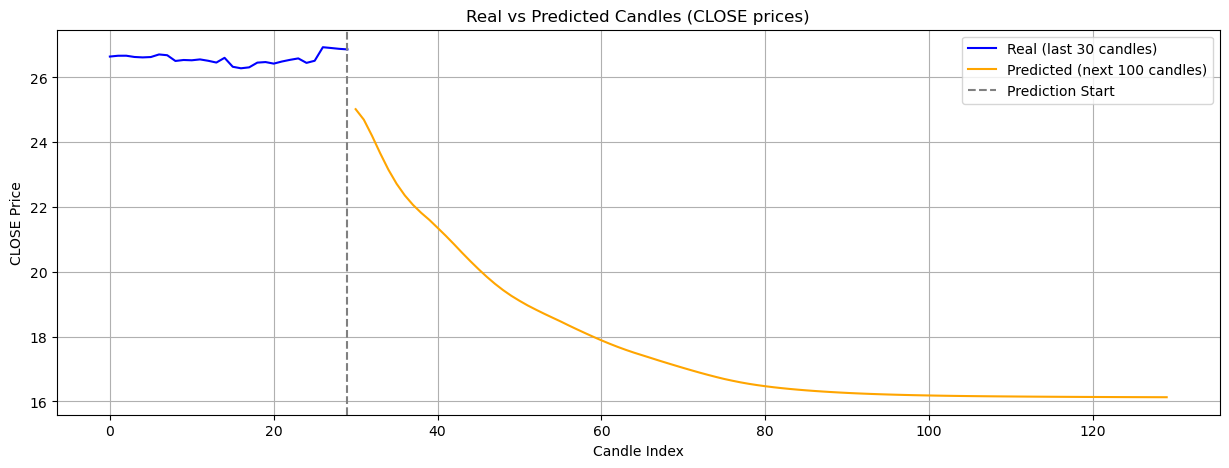

In [13]:
# ==== PLOTTING ====
plt.figure(figsize=(15, 5))
plt.plot(range(30), real_closes, label='Real (last 30 candles)', color='blue')
plt.plot(range(30, 130), predicted_closes, label='Predicted (next 100 candles)', color='orange')
plt.axvline(x=29, linestyle='--', color='gray', label='Prediction Start')
plt.title('Real vs Predicted Candles (CLOSE prices)')
plt.xlabel('Candle Index')
plt.ylabel('CLOSE Price')
plt.legend()
plt.grid(True)
plt.show()